In [112]:
! pip install numpy
! pip install pandas
! pip install matplotlib
! pip install Ipython


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Ian\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Ian\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Ian\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\Ian\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [113]:
#Import Relevant Modules
import re
from datetime import datetime, date
from time import sleep
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

In [114]:
#Retrive today's date
date = date.today()

In [115]:
def getHVData(filename):
    '''
    Extract pressure data from txt file

    @param:
        filename -> str
    
    @return:
        2D list of time and HV current -> list
    '''
    
    data = []                          
    pressure_pattern = re.compile(r'\[\d{4}-\d{2}-\d{2} (.*?)\] Set: \d* V,  HV: \d* V,  I: ([\d\.]*) mA', re.I)
    
    with open(filename, "r") as f:
        for line in f:
            p = pressure_pattern.search(line)
            if p:
                time_str = p.group(1)
                current = p.group(2)
                log_time = datetime.strptime(time_str, "%H:%M:%S.%f").time()

                data.append((log_time, current))
    return data

In [116]:
def getPressureData(filename):
    '''
    Extract pressure data from txt file

    @param:
        filename -> str
    
    @return:
        2D list of Time and Pressure -> list
    '''
    
    data = []                          
    pressure_pattern = re.compile(r'\[(\d{2}:\d{2}:\d{2})\].*?pressure:\s*([0-9.]+E[-+]?\d+)', re.I)
    
    with open(filename, "r") as f:
        for line in f:
            p = pressure_pattern.search(line)
            if p:
                time_str = p.group(1)
                pressure = p.group(2)
                log_time = datetime.strptime(time_str, "%H:%M:%S").time()

                data.append((log_time, pressure))
    return data

In [117]:
def getPMONData(filename):
    '''
    Extract PMON Temperature data from txt file

    @param:
        filename -> str
    @return:
        list with data from each PMON
    '''
    
    data = [] 
    pmon_pattern = re.compile(r'\[(\d{2}:\d{2}:\d{2})\].*?PMON\s+temps:\s*(\{[^}]+\})', re.I)
    with open(filename, "r") as f:
        for line in f:
            p = pmon_pattern.search(line)
            if p:
                time_str = p.group(1)
                log_time = datetime.strptime(time_str, "%H:%M:%S").time()
                
                pmon_dict = eval(p.group(2))
                pmon_1 = pmon_dict[1]
                pmon_2 = pmon_dict[2]
                pmon_3 = pmon_dict[3]
                pmon_4 = pmon_dict[4]
                pmon_5 = pmon_dict[5]
                pmon_6 = pmon_dict[6]

                data.append((log_time, pmon_1, pmon_2, pmon_3, pmon_4, pmon_5, pmon_6))
    return data

In [118]:
def createCurrentCSV(hv_data):
    '''

    @param:
    pressure_data: list of data -> list
    '''
    with open(f'HV_Current_log-'+ str(date) + '.csv', 'w', newline='') as out:
        writer = csv.writer(out)
        writer.writerow(['Time', 'Current (mA)'])   # header
        writer.writerows(hv_data)

    print(f'{len(hv_data)} rows written to HV_Current_log-'+ str(date) + '.csv')

In [119]:
def createPressureCSV(pressure_data):
    '''

    @param:
    pressure_data: list of data -> list
    '''
    #Using 'w' to overwrite existing
    with open(f'pressure_log-'+ str(date) + '.csv', 'w', newline='') as out:
        writer = csv.writer(out)
        writer.writerow(['Time', 'Pressure (mbar)'])   # header
        writer.writerows(pressure_data)
        
    print(f'{len(pressure_data)} rows written to pressure_log-'+ str(date) + '.csv')

In [120]:
def createPMONCSV(pmon_data):
    '''

    @param:
    pmon_data: list of data -> list
    '''
    with open(f'pmon_log-' + str(date) + '.csv', 'w', newline='') as out:
        writer = csv.writer(out)
        writer.writerow(['Time', 'PMON 1', 'PMON_2', 'PMON_3', 'PMON_4', 'PMON_5', 'PMON_6'])   # header
        writer.writerows(pmon_data)

    print(f'{len(pmon_data)} rows written to pmon_log-' + str(date) + '.csv')

In [121]:
def getGraph(pmon_csv, pressure_csv, hv_csv, start_time='00:00:01', end_time='23:59:59'):
    '''
    Displays Graph of PMON, pressure, and HV current (beam current) using multiple panes in one graph window
    Takes 

    args:
        pmon data : list of data -> list
        pressure_data : list of data -> list
        hvCurrent_data : list of data -> list
    
    '''
    ##############################################
    # Process PMON data into a graph-able format #
    ##############################################

    # Read data from CSV and convert timestamps into datetime format
    pmon_result = pd.read_csv(pmon_csv, parse_dates=['Time'])
    pmon_result['timestamp'] = pd.to_datetime(pmon_result['Time'], format='%H:%M:%S')
    pmon_result = pmon_result.to_numpy()
    time_DNE = False

    # Make a list with timestamps from pmon_result to use for graphing
    time = pd.to_datetime(pmon_result[:, 0], format='%H:%M:%S')
    pmon_data = {}

    # Try to make indexes for where to stop and start the graph
    try:
        start_index = time.tolist().index(str(start_time))
        end_index = time.tolist().index(str(end_time))
    except ValueError:
        print("Timeframe does not exist")
        time_DNE = True


    # Convert pmon_result into list of dictionaries
    ports = {1:'PMON_1', 2:'PMON_2', 3:'PMON_3', 4:'PMON_4', 5:'PMON_5', 6:'PMON_6'}

    for idx, value in ports.items():
        if time_DNE == True:
            pmon_data[value] = pmon_result[:, idx].tolist()
        elif time_DNE == False:
            pmon_data[value] = pmon_result[start_index:end_index, idx].tolist()
            
    if time_DNE == False:
        time = time[start_index:end_index]

    # Fill data points that are disconnected with previous value
    for key in ports.values():
        if pmon_data[key][0] in ['DISCONNECTED','SENSOR_ERROR', 'None']:
            pmon_data[key] = [float(x) for x in pmon_data[key] if x not in ('DISCONNECTED','SENSOR_ERROR', 'None')]
        else:
            for i in range(len(pmon_data[key])):
                if pmon_data[key][i] in ['DISCONNECTED','SENSOR_ERROR','None']:
                    pmon_data[key][i] = pmon_data[key][i - 1]
            pmon_data[key] = [float(x) for x in pmon_data[key]]

    ##################################################
    # Process pressure data into a graph-able format #
    ##################################################
    pressure_result = pd.read_csv(pressure_csv, parse_dates=['Time'])

    # Filter by time range
    filtered_pressure = pressure_result[(pressure_result['Time'] >= start_time) & (pressure_result['Time'] <= end_time)]


    ####################################################
    # Process HV current data into a graph-able format #
    ####################################################

    current_result = pd.read_csv(hv_csv, parse_dates=['Time'])

    # Filter by time range
    filtered_current = current_result[(current_result['Time'] >= start_time) & (current_result['Time'] <= end_time)]


    ###################
    # Graph the data! #
    ###################

    fig, axs = plt.subplots(3, 1, figsize=(16, 9), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})

    # --- PMON plot ---
    for key in ports.values():
        axs[0].plot(time, pmon_data[key], label=key)
    axs[0].set_ylabel('PMON Values')
    axs[0].legend(loc='upper right')
    axs[0].grid(True)

    # --- Pressure plot ---
    axs[1].plot(filtered_pressure['Time'].to_numpy(), filtered_pressure['Pressure (mbar)'].to_numpy())
    axs[1].set_ylabel('Pressure (mbar)')
    axs[1].grid(True)

    # --- HV Current plot ---
    axs[2].plot(filtered_current['Time'].to_numpy(), filtered_current['Current (mA)'].to_numpy())
    axs[2].set_ylabel('Current (mA)')
    axs[2].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


24108 rows written to pmon_log-2025-06-11.csv
23856 rows written to pressure_log-2025-06-11.csv
740 rows written to HV_Current_log-2025-06-11.csv


C:\Users\Ian\AppData\Local\Temp\ipykernel_25032\122710437.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pmon_result = pd.read_csv(pmon_csv, parse_dates=['Time'])


Timeframe does not exist


C:\Users\Ian\AppData\Local\Temp\ipykernel_25032\122710437.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pressure_result = pd.read_csv(pressure_csv, parse_dates=['Time'])
C:\Users\Ian\AppData\Local\Temp\ipykernel_25032\122710437.py:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  current_result = pd.read_csv(hv_csv, parse_dates=['Time'])


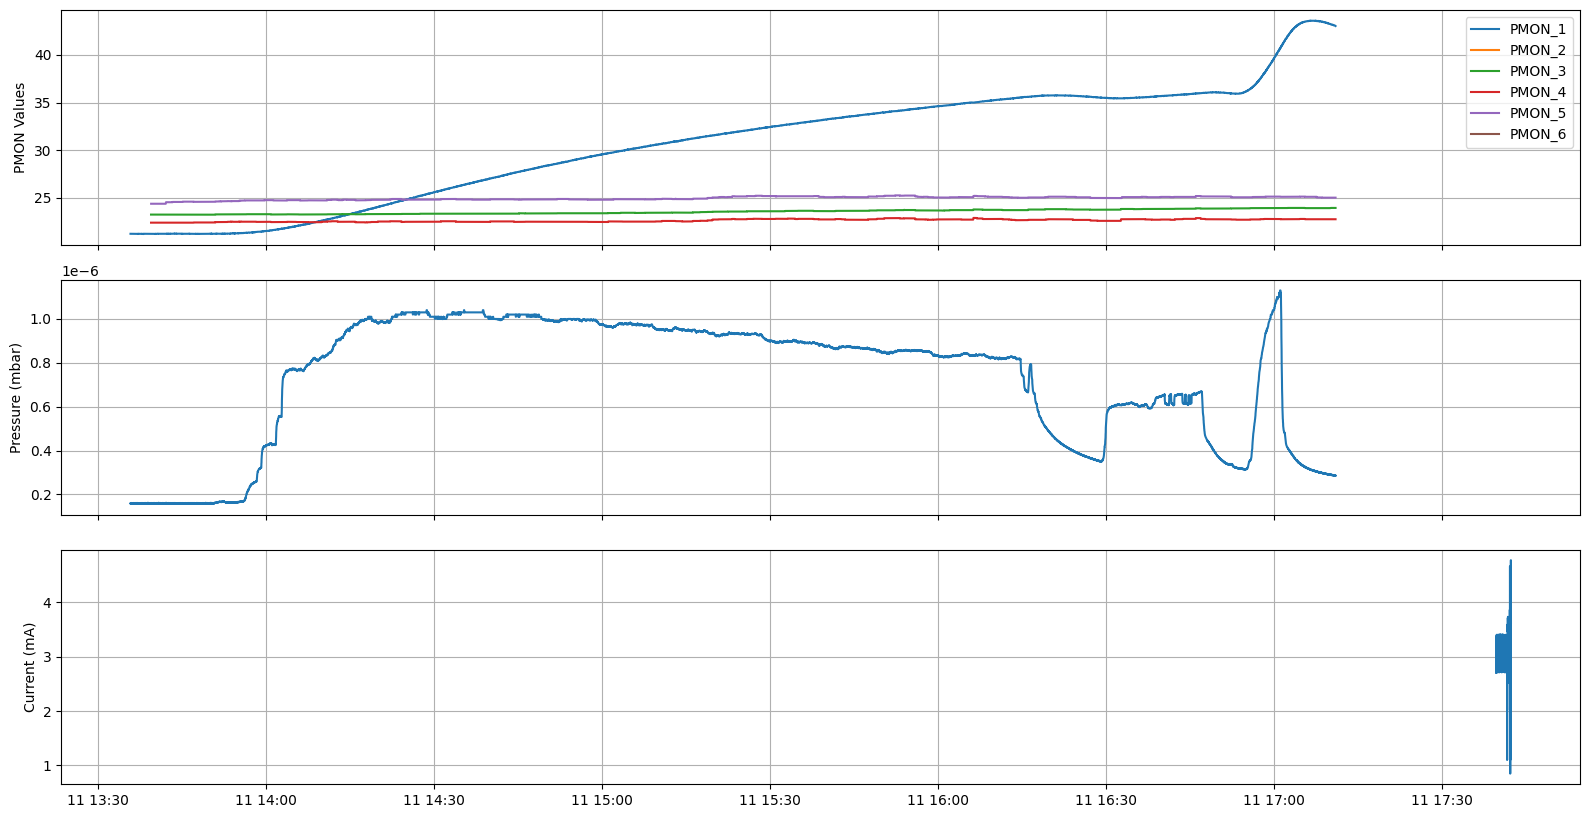

In [122]:
# Log file location on laptop: 'C:/Users/Experiment/EBEAM_dashboard/EBEAM-Dashboard-Logs/'
# Enter your Ebeam dashboard and Tera Term log files here
dashboard_log_file = 'Data samples/log_export_2025-06-09_17-10-43.txt'
teraTerm_log_file = 'Data samples/HV_monitor 2025-06-10.txt'

# If you want to use a CSV that wasn't generated right now, you'll need to change these
pmon_csv = f'pmon_log-' + str(date) + '.csv'
pressure_csv = f'pressure_log-'+ str(date) + '.csv'
hvCurrent_csv = f'HV_Current_log-'+ str(date) + '.csv'

# Create the CSV files
createPMONCSV(getPMONData(dashboard_log_file))
createPressureCSV(getPressureData(dashboard_log_file))
createCurrentCSV(getHVData(teraTerm_log_file))

# Call the function to generate the graph
getGraph(pmon_csv, pressure_csv, hvCurrent_csv)




24108 rows written to pmon_log-2025-06-11.csv
23856 rows written to pressure_log-2025-06-11.csv
740 rows written to HV_Current_log-2025-06-11.csv


C:\Users\Ian\AppData\Local\Temp\ipykernel_25032\122710437.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pmon_result = pd.read_csv(pmon_csv, parse_dates=['Time'])


Timeframe does not exist


C:\Users\Ian\AppData\Local\Temp\ipykernel_25032\122710437.py:60: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pressure_result = pd.read_csv(pressure_csv, parse_dates=['Time'])
C:\Users\Ian\AppData\Local\Temp\ipykernel_25032\122710437.py:70: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  current_result = pd.read_csv(hv_csv, parse_dates=['Time'])


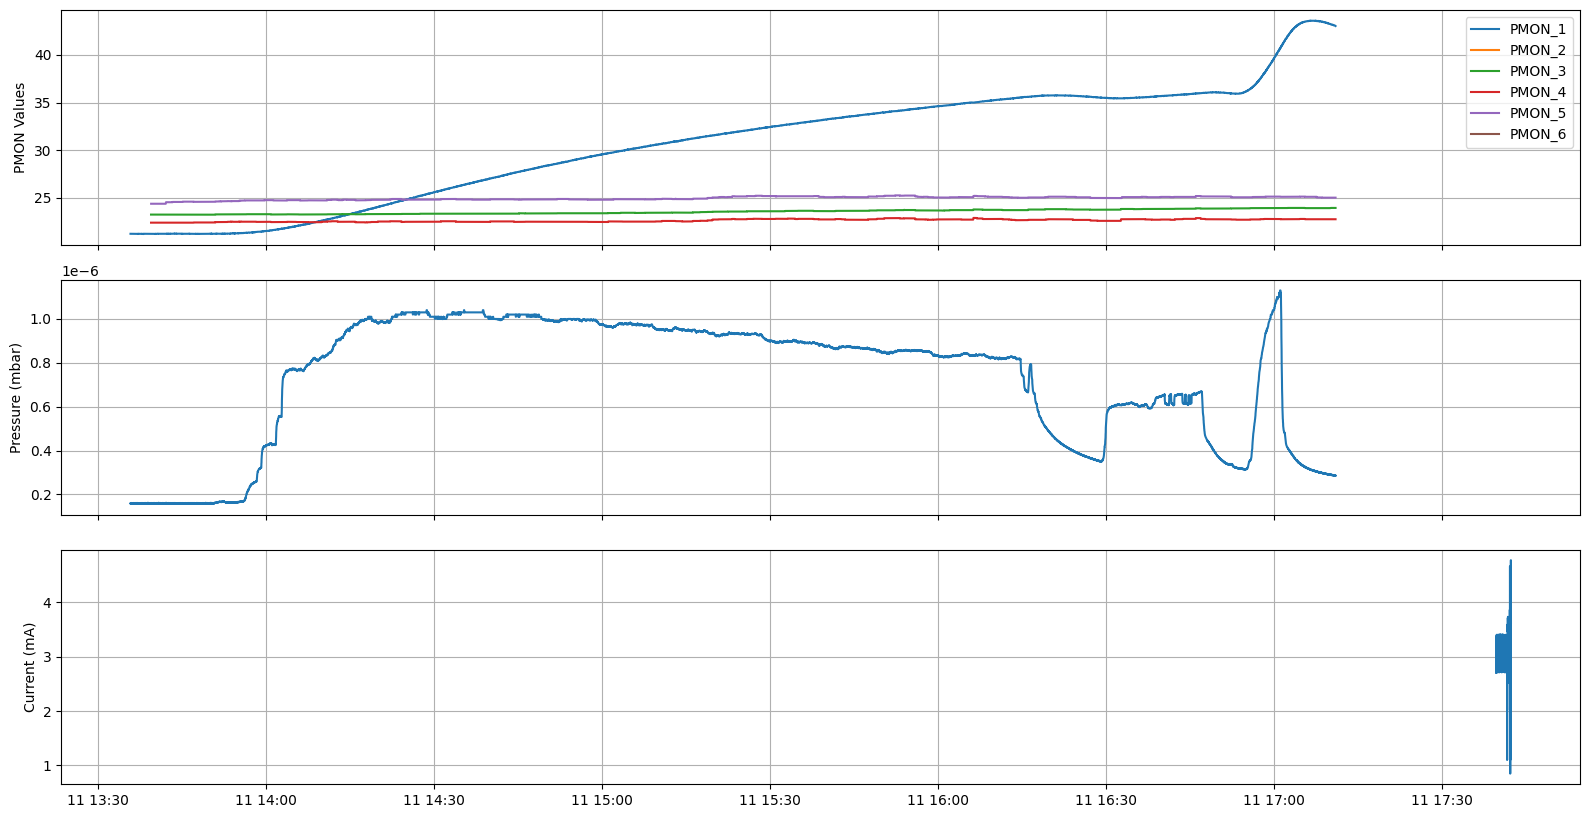

KeyboardInterrupt: 

In [123]:
# Log file location on laptop: 'C:/Users/Experiment/EBEAM_dashboard/EBEAM-Dashboard-Logs/'
# Enter your Ebeam dashboard and Tera Term log files here
dashboard_log_file = 'Data samples/log_export_2025-06-09_17-10-43.txt'
teraTerm_log_file = 'Data samples/HV_monitor 2025-06-10.txt'

# If you want to use a CSV that wasn't generated right now, you'll need to change these
pmon_csv = f'pmon_log-' + str(date) + '.csv'
pressure_csv = f'pressure_log-'+ str(date) + '.csv'
hvCurrent_csv = f'HV_Current_log-'+ str(date) + '.csv'

while 1 :
    # Create the CSV files
    createPMONCSV(getPMONData(dashboard_log_file))
    createPressureCSV(getPressureData(dashboard_log_file))
    createCurrentCSV(getHVData(teraTerm_log_file))

    # Call the function to generate the graph
    getGraph(pmon_csv, pressure_csv, hvCurrent_csv)  
    sleep(10)
    clear_output(wait=True)